In [ ]:
# Cell 1: Cài đặt thư viện
!pip install scikit-learn pandas numpy matplotlib joblib requests beautifulsoup4
!pip install kagglehub

In [ ]:
# Cell 2: Tải và giải nén CSIC HTTP Dataset
import requests, zipfile, io
import kagglehub
# Tải dataset từ Kaggle
path = kagglehub.dataset_download("ispangler/csic-2010-web-application-attacks")
print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/csic-2010-web-application-attacks


In [ ]:
import pandas as pd
import os

# Đường dẫn file CSV sau khi tải về
csv_path = os.path.join(path, 'csic_database.csv')

# Đọc file dữ liệu
df = pd.read_csv(csv_path)
df.head()


,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


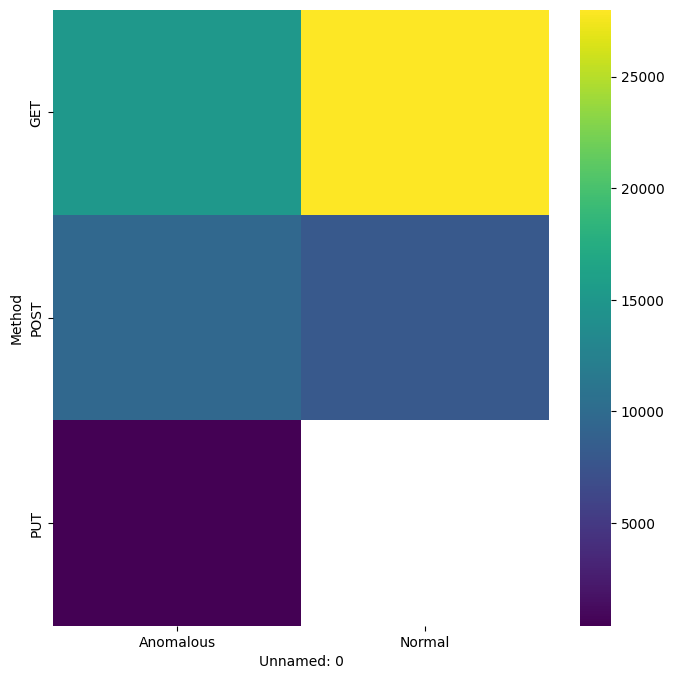

In [ ]:
# @title Unnamed: 0 vs Method

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Method'].value_counts()
    for x_label, grp in df.groupby('Unnamed: 0')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('Method')

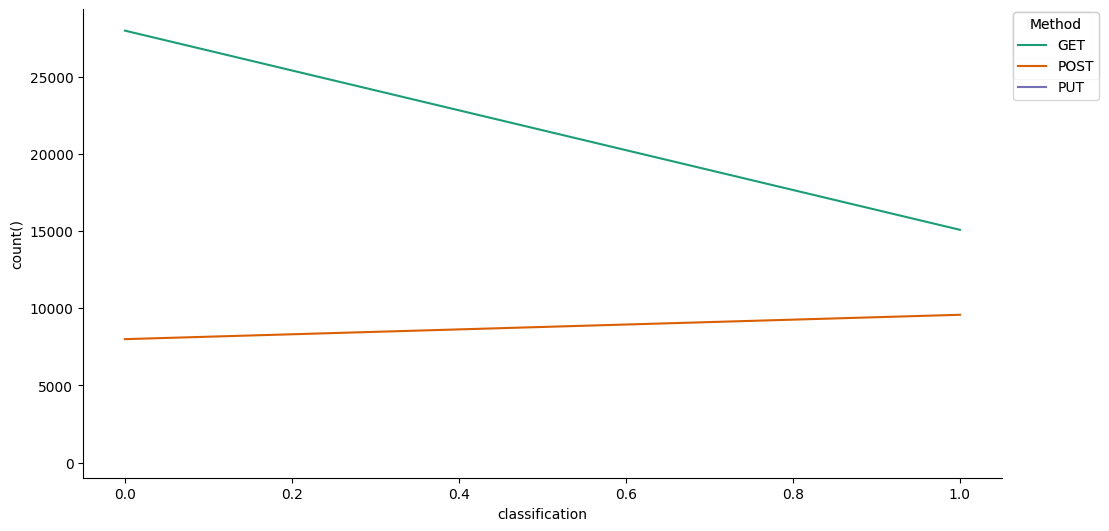

In [ ]:
# @title classification vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['classification']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'classification'}, axis=1)
              .sort_values('classification', ascending=True))
  xs = counted['classification']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('classification', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Method')):
  _plot_series(series, series_name, i)
  fig.legend(title='Method', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('classification')
_ = plt.ylabel('count()')

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Đọc dữ liệu
file_path = path + "/csic_database.csv"
df = pd.read_csv(file_path)

# Tạo cột payload từ URL và content
df['URL'] = df['URL'].fillna('')
df['content'] = df['content'].fillna('')
df['payload'] = df['URL'] + ' ' + df['content']
df['payload'] = df['payload'].astype(str).str.lower()

# Chuẩn hóa nhãn: 0 = benign, 1 = malicious
df['label'] = df['classification']

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=34327)
X = vectorizer.fit_transform(df['payload'])
y = df['label']

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Hoàn tất bước 4: Đã xử lý dữ liệu và chia tập train/test.")


✅ Hoàn tất bước 4: Đã xử lý dữ liệu và chia tập train/test.


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Dictionary lưu kết quả
results = {}

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    results[name] = {
        'acc': round(acc*100, 2),
        'prec': round(prec, 2),
        'rec': round(rec, 2),
        'f1': round(f1, 2)
    }

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1-score: {f1:.2f}")

# Huấn luyện và đánh giá từng mô hình
evaluate_model("Naive Bayes", MultinomialNB())
evaluate_model("Decision Tree", DecisionTreeClassifier(max_depth=20, random_state=42))
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
evaluate_model("SVM (RBF Kernel)", SVC(kernel='rbf', random_state=42))



=== Naive Bayes ===
Accuracy: 96.00%
Precision: 0.94
Recall: 0.97
F1-score: 0.95

=== Decision Tree ===
Accuracy: 94.83%
Precision: 0.99
Recall: 0.89
F1-score: 0.93

=== Random Forest ===
Accuracy: 98.59%
Precision: 0.99
Recall: 0.98
F1-score: 0.98

=== SVM (RBF Kernel) ===
Accuracy: 98.94%
Precision: 1.00
Recall: 0.98
F1-score: 0.99


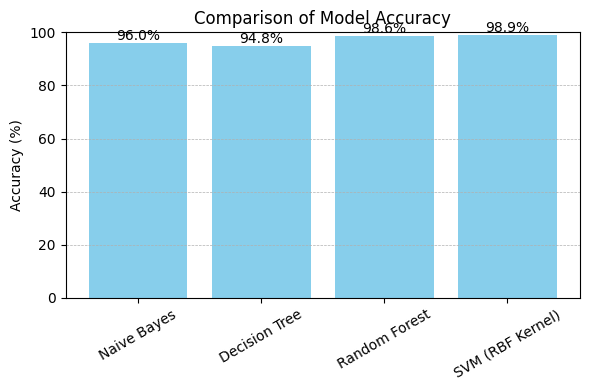

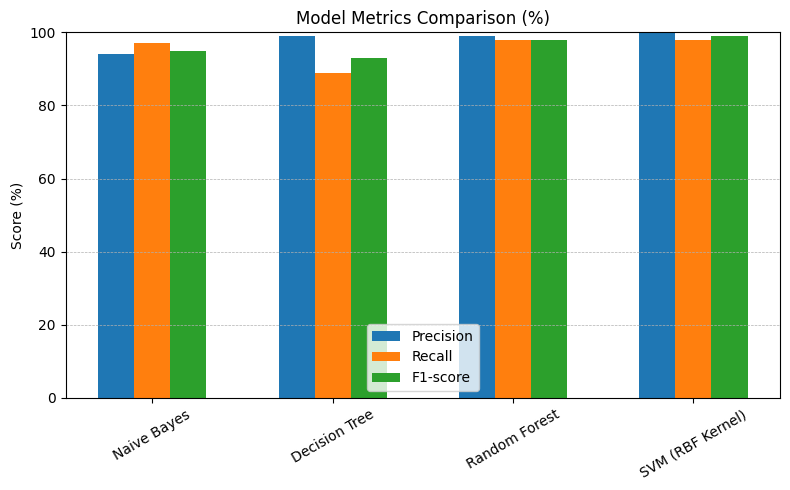

In [ ]:
# Cell 6: Vẽ biểu đồ so sánh Accuracy và các metrics (Precision, Recall, F1-score)

import matplotlib.pyplot as plt
import numpy as np

# Chuẩn bị dữ liệu từ biến results
models = list(results.keys())
acc_vals  = [results[m]['acc'] for m in models]
prec_vals = [results[m]['prec'] * 100 for m in models]  # đã lưu sẵn là phần trăm cho Accuracy, precision, recall, f1 lưu ở [0,1]
rec_vals  = [results[m]['rec'] * 100 for m in models]
f1_vals   = [results[m]['f1'] * 100 for m in models]

x = np.arange(len(models))
width = 0.2

# 1) Bar chart riêng cho Accuracy
plt.figure(figsize=(6,4))
plt.bar(x, acc_vals, color='skyblue')
plt.xticks(x, models, rotation=30)
plt.ylim(0, 100)
plt.title('Comparison of Model Accuracy')
plt.ylabel('Accuracy (%)')
for i, v in enumerate(acc_vals):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# 2) Bar chart nhóm cho Precision, Recall và F1-score
plt.figure(figsize=(8,5))
plt.bar(x - width, prec_vals, width, label='Precision')
plt.bar(x,       rec_vals, width, label='Recall')
plt.bar(x + width,f1_vals,  width, label='F1-score')
plt.xticks(x, models, rotation=30)
plt.ylim(0, 100)
plt.title('Model Metrics Comparison (%)')
plt.ylabel('Score (%)')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Tạo Flask app giả lập xử lý yêu cầu (chỉ demo logic, không chạy server thật)
from flask import Flask, request

# Tập hợp các mô hình đã huấn luyện vào dictionary
models = {
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42)
}

# Huấn luyện lại để đảm bảo mỗi model đều đã được fit
for name, model in models.items():
    model.fit(X_train, y_train)

# Mô phỏng quá trình "dự đoán" từ input mới (giả lập WAF nhận request từ client)
test_requests = [
    "GET /index.jsp HTTP/1.1",
    "POST /login.jsp HTTP/1.1\r\nUser=admin';--",
    "GET /../../etc/passwd HTTP/1.1",
    "POST /product.jsp HTTP/1.1\r\nid=3&quantity=10"
]

# Chuyển về payload giống như dữ liệu huấn luyện
test_payloads = [req.lower() for req in test_requests]

# Dùng lại vectorizer đã fit từ df['payload']
X_demo = vectorizer.transform(test_payloads)

# Dự đoán từng yêu cầu theo từng mô hình
print("=== ML-WAF Test Results for All Models ===")
for name, model in models.items():
    # Chuyển đổi test_requests thành dạng vector theo vectorizer đã fit với df['payload']
    X_demo = vectorizer.transform(test_payloads)  # Chắc chắn vectorizer được áp dụng trên dữ liệu kiểm thử đã xử lý

    # Dự đoán
    y_pred = model.predict(X_demo)

    print(f"\n--- {name} ---")
    for i, req in enumerate(test_requests):
        label = 'Attack' if y_pred[i] == 1 else 'Normal'
        print(f"Request: {req}\n=> Prediction: {label}\n")


=== ML-WAF Test Results for All Models ===

--- Naive Bayes ---
Request: GET /index.jsp HTTP/1.1
=> Prediction: Normal

Request: POST /login.jsp HTTP/1.1
User=admin';--
=> Prediction: Attack

Request: GET /../../etc/passwd HTTP/1.1
=> Prediction: Normal

Request: POST /product.jsp HTTP/1.1
id=3&quantity=10
=> Prediction: Normal


--- Decision Tree ---
Request: GET /index.jsp HTTP/1.1
=> Prediction: Attack

Request: POST /login.jsp HTTP/1.1
User=admin';--
=> Prediction: Attack

Request: GET /../../etc/passwd HTTP/1.1
=> Prediction: Attack

Request: POST /product.jsp HTTP/1.1
id=3&quantity=10
=> Prediction: Attack


--- Random Forest ---
Request: GET /index.jsp HTTP/1.1
=> Prediction: Attack

Request: POST /login.jsp HTTP/1.1
User=admin';--
=> Prediction: Attack

Request: GET /../../etc/passwd HTTP/1.1
=> Prediction: Attack

Request: POST /product.jsp HTTP/1.1
id=3&quantity=10
=> Prediction: Attack


--- SVM (RBF Kernel) ---
Request: GET /index.jsp HTTP/1.1
=> Prediction: Normal

Request

<Figure size 1200x600 with 0 Axes>

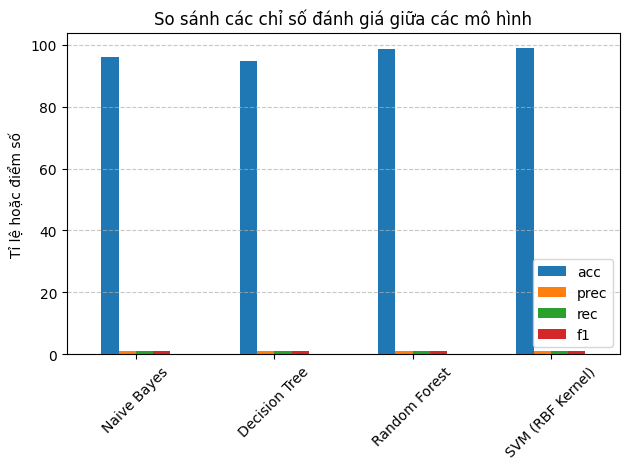

<Figure size 500x400 with 0 Axes>

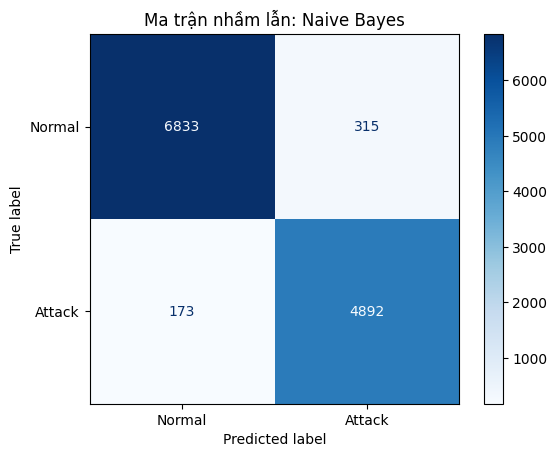

<Figure size 500x400 with 0 Axes>

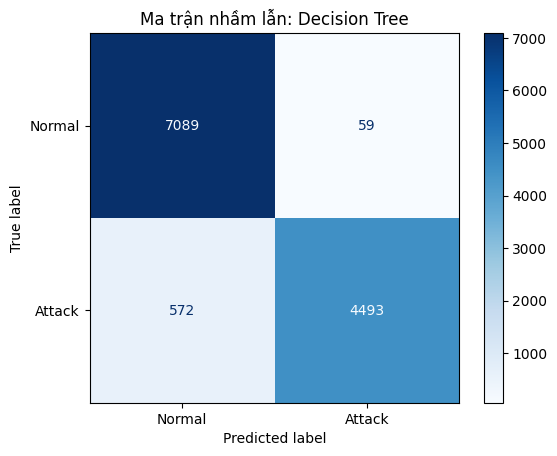

<Figure size 500x400 with 0 Axes>

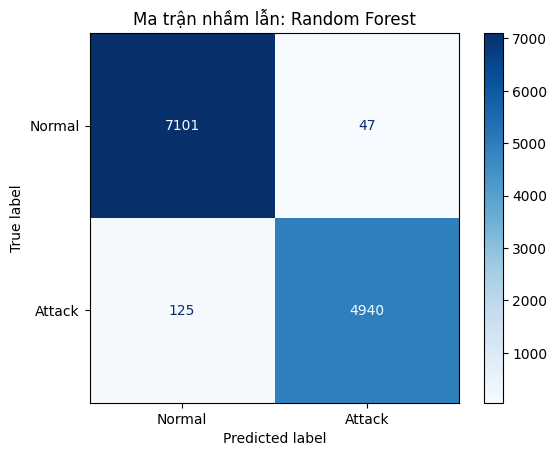

<Figure size 500x400 with 0 Axes>

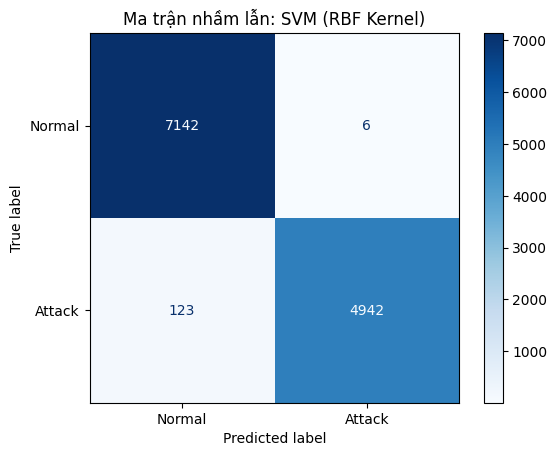

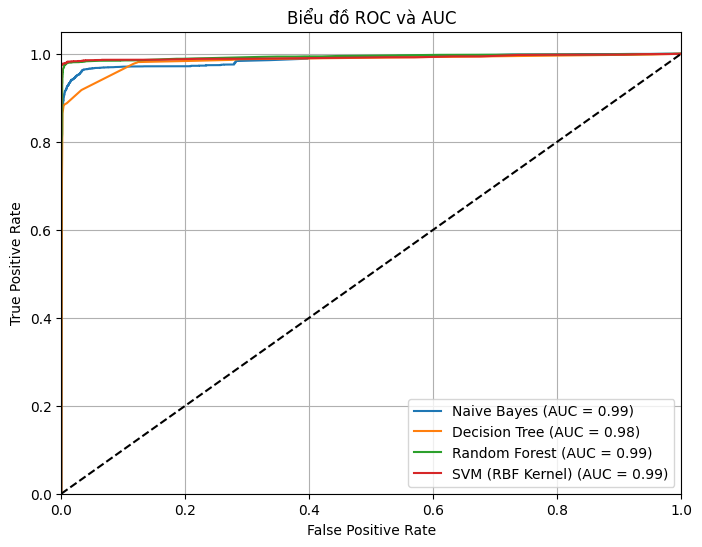

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# ==== 1. Biểu đồ cột: So sánh Accuracy, Precision, Recall, F1 ====
results_df = pd.DataFrame(results).T  # Chuyển dict kết quả sang DataFrame
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar')
plt.title("So sánh các chỉ số đánh giá giữa các mô hình")
plt.ylabel("Tỉ lệ hoặc điểm số")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# ==== 2. Ma trận nhầm lẫn: Confusion Matrix ====
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])

    plt.figure(figsize=(5, 4))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Ma trận nhầm lẫn: {name}')
    plt.grid(False)
    plt.show()


# ==== 3. ROC Curve + AUC (chỉ cho mô hình hỗ trợ) ====
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue  # Bỏ qua nếu không hỗ trợ

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Đường baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Biểu đồ ROC và AUC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


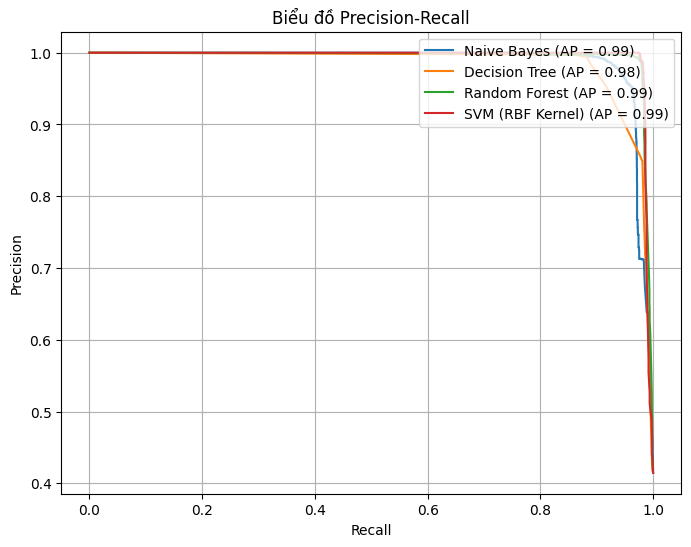

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    avg_precision = average_precision_score(y_test, y_score)

    plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Biểu đồ Precision-Recall')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
